In [1]:
import sys
import numpy as np
from pathlib import Path
from keras import datasets
import matplotlib.pyplot as plt

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent))

# Import modules from the custom library
from src import Tensor
from src.core.utils import context_manager
from src.architectures.sequential import Sequential

### Constants


In [2]:
# Define constants
model_path = Path().resolve() / 'checkpoints' / 'autoencoder'
n_images = 50
batch_size = 512

### Load the model


In [3]:
# Load the trained model
autoencoder: Sequential = Sequential.load(str(model_path))

# Set the model to evaluation mode
autoencoder.eval()

In [4]:
# Load MNIST to estimate the latent distribution
(train_images, _), _ = datasets.mnist.load_data()

# Normalize and add channel dimension
train_images = np.expand_dims(train_images.astype(np.float32) / 255.0, axis=-1)
X_train = Tensor(train_images)
X_train_flatten = X_train.reshape((X_train.shape[0], -1))

### Generation


In [5]:
# Access encoder and decoder modules
encoder: Sequential = autoencoder.modules[0]
decoder: Sequential = autoencoder.modules[1]

# Read latent dimension from the encoder
latent_dim = encoder.modules[-1].num_units

# Set the context manager to no_grad to disable gradient tracking during inference
with context_manager.no_grad():
    # Encode training samples to estimate latent distribution
    train_latent = encoder(x=X_train_flatten, batch_size=batch_size).output

# Estimate latent distribution statistics
latent_mean = train_latent.data.mean(axis=0)
latent_std = train_latent.data.std(axis=0) + 1e-6

# Sample latent vectors from the empirical latent distribution
z = Tensor(latent_mean + np.random.randn(n_images, latent_dim) * latent_std, dtype=np.float32)

# Set the context manager to no_grad to disable gradient tracking during inference
with context_manager.no_grad():
    # Generate images using the decoder
    generated_flat = decoder(x=z).output

# Reshape generated images to the original image shape
generated_images = generated_flat.reshape((-1, *X_train.shape[1:]))

### Display generated images


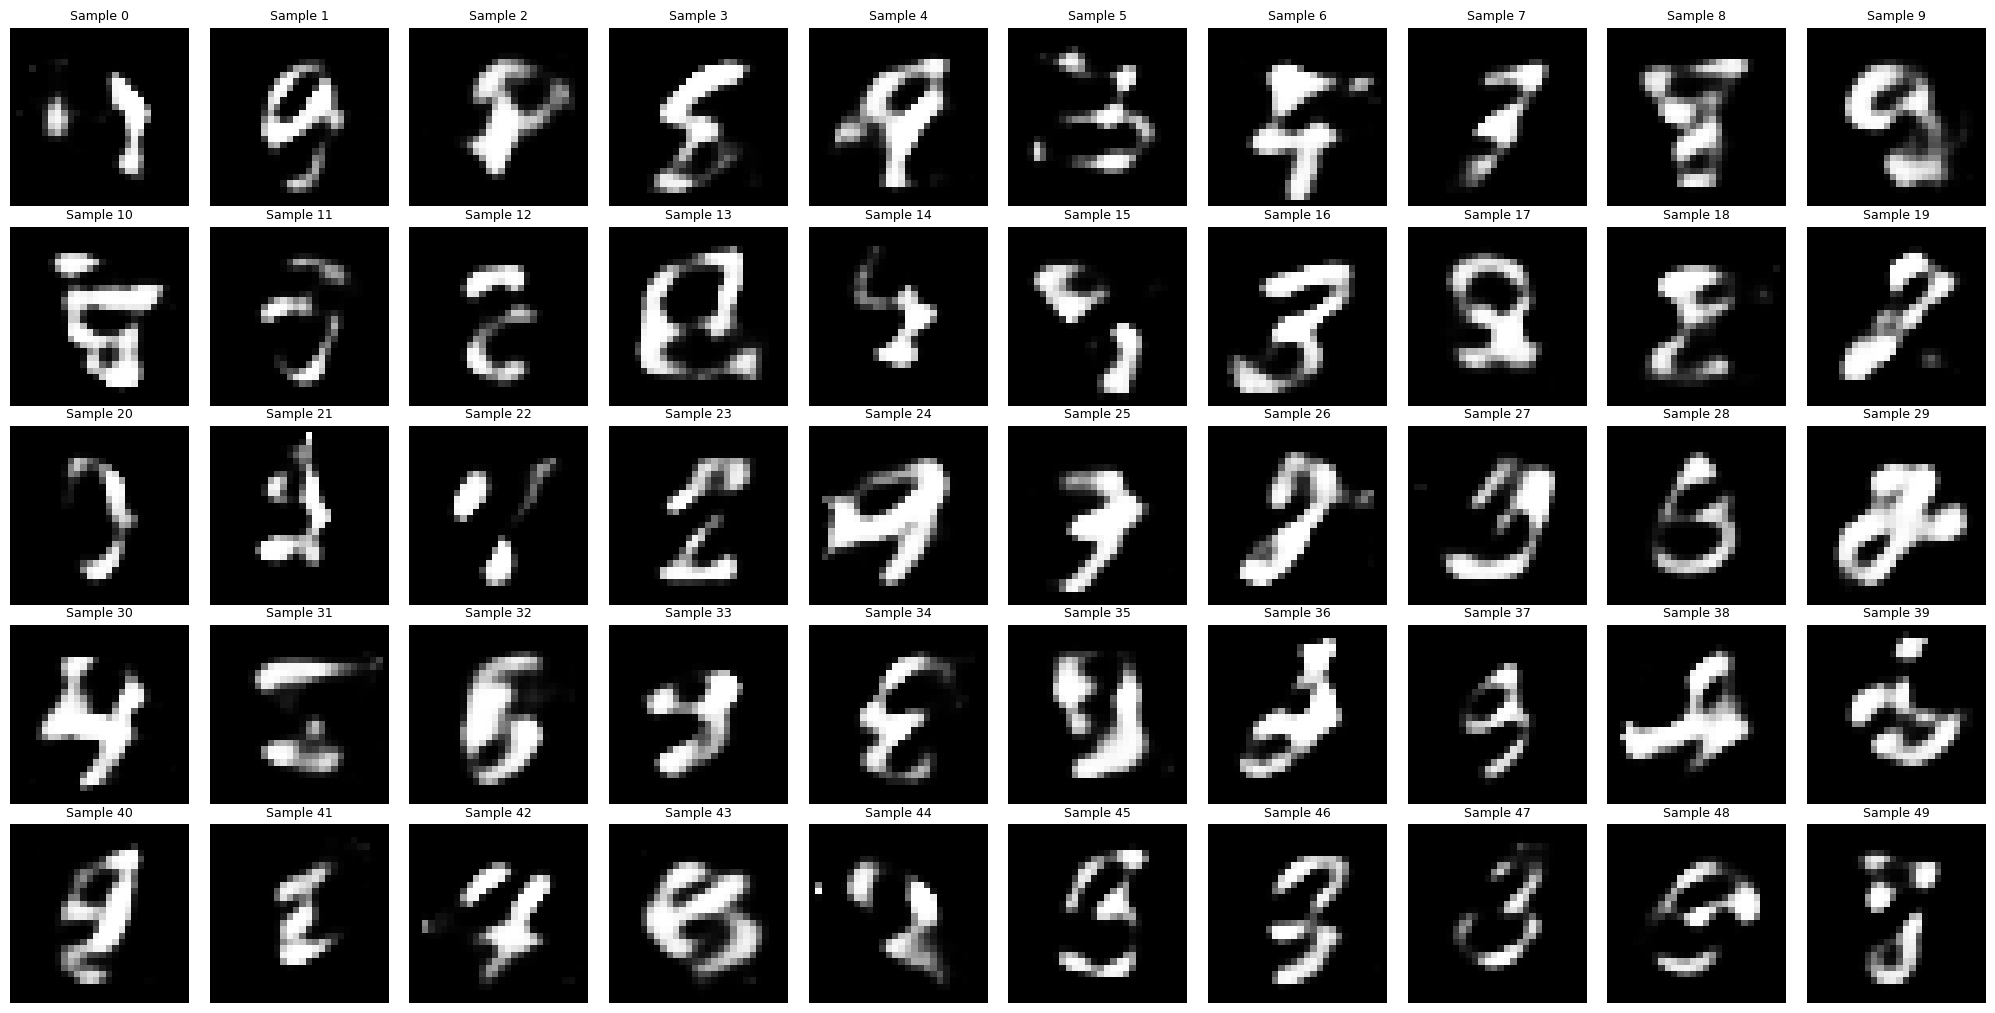

In [6]:
# Plot generated images
n_cols = 10
n_rows = int(np.ceil(n_images / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))
axes = np.array(axes).reshape(n_rows, n_cols)

# Convert generated images to numpy for plotting
images_np = generated_images.to_numpy()

# Plot each generated image in the corresponding subplot
for idx in range(n_rows * n_cols):
    ax = axes[idx // n_cols, idx % n_cols]
    ax.axis('off')
    if idx < n_images:
        ax.imshow(images_np[idx], cmap='gray')
        ax.set_title(f'Sample {idx}', fontsize=9)

# Adjust layout and display the plot
plt.tight_layout(pad=0.25)
plt.show()